# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rkstiff.grids import construct_x_kx_rfft
from rkstiff.etd34 import ETD34
%matplotlib inline

# Construct grids

In [2]:
# uniform grid spacing, field assumed to be real-valued -> construct_x_kx_rfft
N = 512
a, b = -150, 150
x,kx = construct_x_kx_rfft(N,a,b)

# Linear and nonlinear functions for spectral kdV equation

In [3]:
L = 1j*kx**3

def NLfunc(uf):
    print(uf.shape)
    u = np.fft.irfft(uf)
    ux = np.fft.irfft(1j*kx*uf)
    return -6*np.fft.rfft(u*ux)

# Initial values set to a combination of kdV solitons

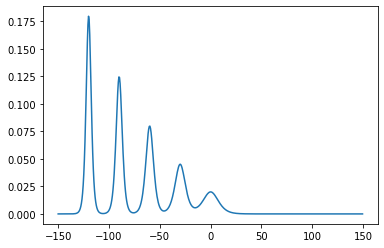

In [4]:
A0 = np.array([0.6, 0.5, 0.4, 0.3, 0.2]).reshape(1,5)
x0 = np.array([-120, -90, -60, -30, 0]).reshape(1,5)
u0 = 0.5*A0**2/(np.cosh(A0*(x.reshape(N,1)-x0)/2)**2)
u0 = np.sum(u0,axis=1)
u0FFT = np.fft.rfft(u0)

plt.plot(x,u0)

# Initialize ETD34 solver

In [5]:
solver = ETD34(linop=L,NLfunc=NLfunc)
solver.epsilon = 1e-4

# Propagate step by step

(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)

(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)

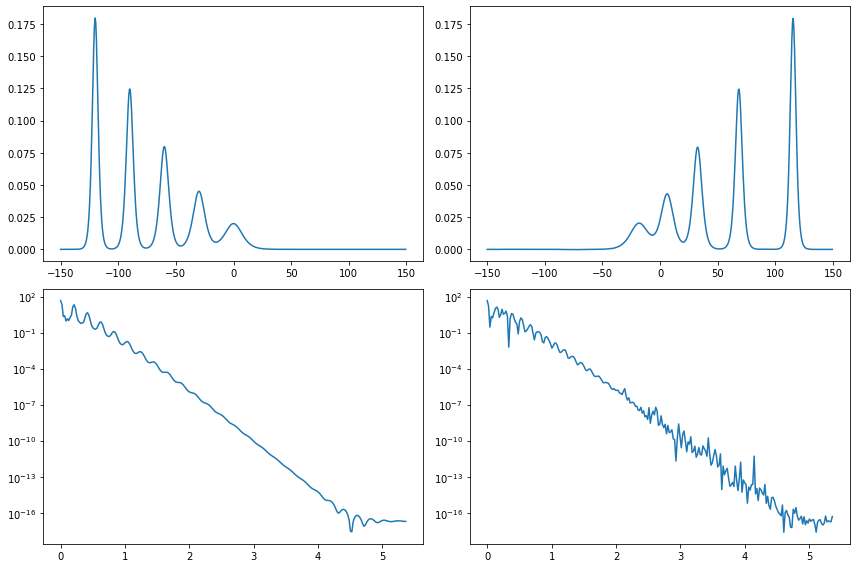

In [6]:
maxsteps = 10000
uFFT = u0FFT.copy()
t, h = 0, 0.1
stepnum = 0
while t < 600 and stepnum < maxsteps:
    uFFT,h,h_suggest = solver.step(uFFT,h)
    t += h
    # use suggested step (or not for a constant step size scheme)
    h = h_suggest 
    stepnum += 1
    
print('tf = ',t)
uf = np.fft.irfft(uFFT)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2,sharey = ax1)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4,sharey = ax3)
ax1.plot(x,u0)
ax2.plot(x,uf)
ax3.plot(kx,np.abs(u0FFT)**2)
ax4.plot(kx,np.abs(uFFT)**2)
ax3.set_yscale('log')
ax4.set_yscale('log')
fig.tight_layout()

# Propagate from time t0 to tf

In [7]:
# store_data -> propagated field stored in ETD34.u at times ETD34.t 
# store_freq -> propagated field values stored on every store_freq step (default is every step)
uFFT = solver.evolve(u0FFT,t0=0,tf=600,store_data=True,store_freq=25)

(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)

(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)
(257,)

In [8]:
print(np.linalg.norm(u0FFT))
print(np.linalg.norm(uFFT))
print((np.linalg.norm(u0FFT)-np.linalg.norm(uFFT))/np.linalg.norm(uFFT))

12.318000488292395
12.311050732139744
0.0005645136474425405


In [9]:
def waterfall(x,t,u,**kwargs):
    if 'figsize' in kwargs:
        fig = plt.figure(figsize=kwargs['figsize'])
    else:
        fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.w_xaxis.set_pane_color((0,0,0,0))
    ax.w_yaxis.set_pane_color((0,0,0,0))
    ax.w_zaxis.set_pane_color((0,0,0,0))
    for i,snapshot in enumerate(u):
        ax.plot(x,t[i]*np.ones_like(x),snapshot,color='black')
    plt.xlim([x[0],x[-1]])
    plt.ylim([t[0],t[-1]])
    plt.tight_layout()
    return ax

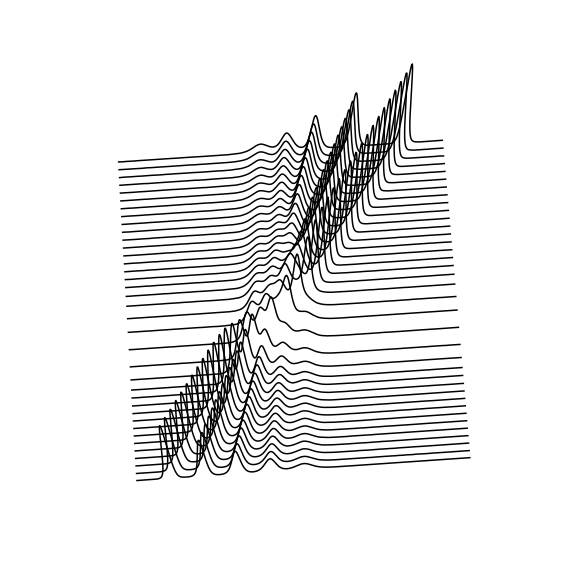

In [10]:
U = []
for u in solver.u:
    U.append(np.fft.irfft(u))
U = np.array(U)
t = np.array(solver.t)
ax = waterfall(x,t,U,figsize=(8,8))
ax.grid(False)
ax.axis(False)
ax.view_init(75,-94)